<a href="https://colab.research.google.com/github/ZHAO0428/zhao0428.github.io/blob/main/L6a_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIDM7340 AI for Digital Media
# Tutorial: Generate Mnist Images with a DCGAN.
In this tutorial, we are using one of the simplest Datasets, made up of 28 × 28 images of handwritten numbers in grayscale, which is the MNIST dataset.

We will be closely following one of the first major papers on GANs, “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” In this 2015 paper, the authors show how to build a deep convolutional GAN to generate realistic images from a variety of datasets.

In this tutorial, we will use several of the recommendations launched by Soumith Chintala, known as [GAN Hacks](https://github.com/soumith/ganhacks). This will ensure that the GAN is correctly optimized for the dataset used.

## 0. Preparation

To generate GIFs

In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-c0ujji4m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-c0ujji4m
  Resolved https://github.com/tensorflow/docs to commit 9d688b86c4564044a8de72783c1eb941a4e1c7b6
  Preparing metadata (setup.py) ... done


In [3]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import math

import imageio
import glob

print (tf.__version__)

2.18.0


In [4]:
def plot_results(images, n_cols, epoch_num=None):
    '''visualizes fake images'''
    display.clear_output(wait=False) # clears the previous output in an interactive environment

    n_rows = math.ceil(len(images) / n_cols)

    # If the images have a single color channel (e.g., grayscale images with shape [height, width, 1]), this line removes the last dimension, converting them to shape [height, width]. This makes them easier to display with plt.imshow.
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    fig = plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "binary")
        plt.axis("off")

    if epoch_num is not None:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch_num))

## 1. Dataset

When loadint the data, the first tuple contains the training data (`X_train`) and the corresponding labels (which are not used here, hence the `_`).
The second tuple contains the test data (which are also not used here, hence the `_`)

In [5]:
# download the training images
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # normalize pixel values from the range [0, 1] to the range [-1, 1]. This is often done to improve the performance of certain neural network models.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1) # allows the dataset to prefetch 1 batch ahead of time, improving training performance

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 2. Build the model
A GAN is used to train a generative model, that is, to produce content. It consists of two models that work together. Once trained, the generative model can be detached from the GAN and used on its own.

The types of models we can find in a GAN are:

**Generator Model**: It is responsible for producing the images, or the content, that we want to be generated by the GAN.

**Discriminator model**. Decide when an image is true or false.

**GAN model**. The sum of the two models.
### 2.1 Genrator
As input, the generator will receive random data, which we could call `noise`.

For an input of size `noise_input`, the model should produce an output of 28 x 28 x 1. The 1 is because being a grayscale image.

Let’s see the simple way to create the first layers of the builder:


In [6]:
    keras.layers.Input(shape=(noise_input,)),
    keras.layers.Dense(7 * 7 * 128, activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.Reshape([7, 7, 128]),

NameError: name 'noise_input' is not defined

In the first, the `Input` layer takes the noise input then feed to the dense layer. The `Reshape` layer changes the data shape in order to make it easier to transform so that it reaches the output of the last layer with the shape of the image.

As the output of the model, we want to obtain a 28×28 image. For now, after these layers, we have a 7×7 shape with 128 features. We will have to upsample to go from 7×7 to 14×14.

In [7]:
keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(negative_slope=0.2)),

(<Conv2DTranspose name=conv2d_transpose, built=False>,)

The layer for upsampling is `Conv2DTranspose`. Putting a 2 on the `strides`, **doubles** the size of the output, giving us 14×14 instead of 7×7. The size of the kernel is recommended to keep it as a factor of the strides, so we set it to 4. The LeakyRelu activation, unlike a standard Relu, allows negative values. Instead of adjusting any negative value to 0, it will do so by multiplying the `negative_slope` * `value`. That is, a negative value of -2 in our case would be -2 * 0.2 = -0.4. With this the passage of information through the network is smoother since negative values are not cut off so heavily (this is the first recommandation from [GAN Hacks](https://github.com/soumith/ganhacks)).

In [8]:
keras.layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh')

<Conv2DTranspose name=conv2d_transpose_1, built=False>

To achieve an output size of 28×28, another `Conv2DTranspose` layer is needed to perform another upsampling. Another recommendation is to use the `tanh` activator on the last layer of the model. It restricts the output of the layer to a range of values between 0 and 1. Its gradients are also more stable than a sigmoid activator, and can help improve speed and stability.

Let's put all the parts together to make the whole generator. Here we embed two `BatchNormalization` layers between the `Conv2DTranspose` layers. Trying to smooth out the result of the different layers, also helps to improve stability and training speed.

In [9]:
noise_input = 50 # size of noise input

generator = keras.models.Sequential([
    keras.layers.Input(shape=(noise_input,)),
    keras.layers.Dense(7 * 7 * 128, activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 14x14
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 28x28
    keras.layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),
])

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         319,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,217 (2.23 MB)

 Trainable params: 584,705 (2.23 MB)

 Non-trainable params: 512 (2.00 KB)

The input noise data take the form of a vector following a Gaussian distribution. Below we create a vector with 16 x `noise_input` of random values that follow a Gaussian distribution.

shape of the generated batch: (16, 28, 28, 1)


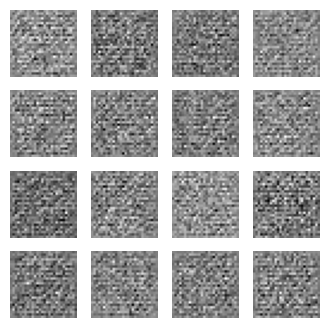

In [10]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
fig = plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

### 2.2 Discriminator
This model is responsible for deciding if an image is true or false. Therefore, as input, it will receive a 28×28×1 image, and as output, it will have a binary value.  
The discriminator model is simpler than the generator. We reduce the input data dimensions using the convolutional layers and a stride of 2, so the input data dimensions are halved. Before sending the data to the last dense layer, we flatten it with the `Flatten` layer. The final `Dense` layer uses a `sigmoid` activator because we are only interested in the values 0 and 1.

In [11]:
discriminator = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28, 1]),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        ),
    keras.layers.Dropout(0.4), # it randomly "drops out" (sets to zero) a fraction of the neurons to prevent overfitting
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           3,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,729 (163.00 KB)

 Trainable params: 41,729 (163.00 KB)

 Non-trainable params: 0 (0.00 B)

The GAN model is to put the generator and the discriminator together.

In [12]:
gan = keras.models.Sequential([generator, discriminator])

In [13]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │         585,217 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │          41,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 626,946 (2.39 MB)

 Trainable params: 626,434 (2.39 MB)

 Non-trainable params: 512 (2.00 KB)

### 3. Compile
In the training process of a GAN, the generator and discriminator are trained alternately:

Training the Discriminator: Use `optimizer_disc` to update only the discriminator's weights.  
Training the Generator: Use `optimizer_gan` to train the entire GAN model, but only update the generator's weights since `discriminator.trainable = False`.
This separation is crucial because the generator and discriminator have different objectives and training steps:

- Discriminator Training: The discriminator's goal is to distinguish between real and generated data, so it needs to be trained separately, updating only its own weights.
- Generator Training: The generator's goal is to produce realistic data to fool the discriminator. During this training, the generator receives feedback through the GAN model, but only the generator's weights should be updated, keeping the discriminator's weights unchanged.

`beta_1=0.5`: This is the exponential decay rate for the first moment estimates (the mean of the gradients), which helps in smoothing the optimization process.

In [14]:
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gan = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gan)

### 4. Train the model
We train the two models together in a function.  
Let’s see the code to train the discriminator. Since we want to train the Discriminator, it is essential that we make sure that its layers can be trained, so we put the value `True` in its trainable attribute before the call to `train_on_batch`.


In [16]:
            # Train the discriminator
            # create the random gaussian noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Generate fake images from the noise
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # mark the discriminator as trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator.
            discriminator.train_on_batch(mixed_images, discriminator_labels)

NameError: name 'batch_size' is not defined

Let’s look at the code train the generator.  
We pass the generated noise and the labels to the GAN so that by executing the generator and the discriminator, it adjusts the weights of the generator to produce better-quality images at each step.

The generator produces a fake image but label it as 1 (i.e., real image). The discriminator returns a value of 0 if it thinks the image is fake or a value of 1 if it thinks the image is real. In the early epochs, the discriminator will be able to identify all false images. As a result, the generator will adjust the weights as much as possible.



In [17]:
            # Train the generator
            # create a new batch of random noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated FAKE images as "real ones"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Mark the discriminator as non trainable.
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

NameError: name 'batch_size' is not defined

Here, labeling the fake images as 1 (real) helps in calculating the loss for the generator. When training the generator, the discriminator takes the generated fake images and outputs a probability for each image, indicating **how real it thinks the image is**. We assign label `1` to fake images means that we want the discriminator's ouput is `1`. The loss function measures the difference between the discriminator's prediction and the desired output (which is 1). The generator's goal is to minimize this loss.

Let’s see the complete code of the GAN training function:

In [19]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs):

    #We obtained the generator and discriminator from the layers of the GAN model.
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))

        #The data is organized into batches when we load it.
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator
            # create the random gaussian noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Generate fake images from the noise
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # mark the discriminator as trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator.
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator
            # create a new batch of random noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated FAKE images as "real ones"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Mark the discriminator as non trainable.
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_results(fake_images[:20], 4, epoch + 1)
        plt.show()

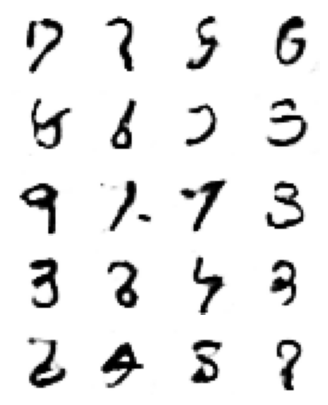

In [20]:
train_gan(gan, dataset, noise_input, 30)

After 30 epochs, the model can generate images like hand-written digits.

### Create a GIF
Use imageio to create an animated gif using the images saved during training. Here is an example of 30 epochs:
<a href="https://raw.githubusercontent.com/xiaoyifu777/AIDM7040/refs/heads/main/figs/dcgan.gif" class="underline" target="_blank">sample gif</a>


In [21]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.v3.imread(filename)
        writer.append_data(image)
    image = imageio.v3.imread(filename)
    writer.append_data(image)


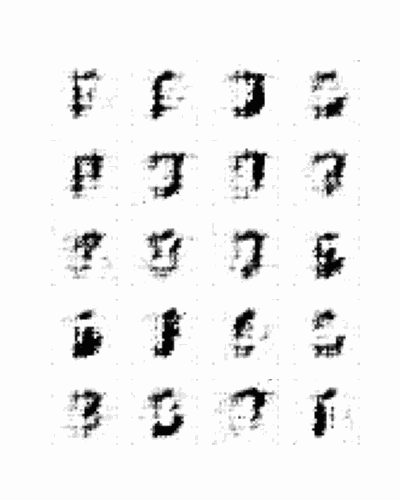

In [22]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Reference
- https://pub.towardsai.net/creating-our-first-optimized-dcgan-12edde5e34c6
- https://www.tensorflow.org/tutorials/generative/dcgan